In [5]:
# Imports
# Standard

# 3rd party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Compcate
import compcate.experiments.experiment_simulation

In [6]:
def agg_data(res):
    agg_dim = ["vary_model", "vary_param", "vary_value", "t_horizon"]
    res_mean = res.groupby(agg_dim).mean().reset_index()
    res_se = res.groupby(agg_dim).sem().reset_index()
    return res_mean, res_se

In [7]:
compcate.experiments.experiment_simulation.run_experiment_by_setting(
    file_name="test_tutorial", n_exp=1, setting="1"
)

Experiment 0, vary_val 0: Fitting model nv.
Experiment 0, vary_val 0: Fitting model cs_cf.
Experiment 0, vary_val 0: Fitting model cs_w.
Experiment 0, vary_val 0: Fitting model cs_west.
Experiment 0, vary_val 0: Fitting model sep_cf.
Experiment 0, vary_val 0: Fitting model sep_w.
Experiment 0, vary_val 0: Fitting model sep_west.
Experiment 0, vary_val 0: Fitting model elim_cf.
Experiment 0, vary_val 0: Fitting model elim_w.
Experiment 0, vary_val 0: Fitting model elim_west.
Experiment 0, vary_value 0: Completed all model training.
Experiment 0, vary_val 2: Fitting model nv.
Experiment 0, vary_val 2: Fitting model cs_cf.
Experiment 0, vary_val 2: Fitting model cs_w.
Experiment 0, vary_val 2: Fitting model cs_west.
Experiment 0, vary_val 2: Fitting model sep_cf.
Experiment 0, vary_val 2: Fitting model sep_w.
Experiment 0, vary_val 2: Fitting model sep_west.
Experiment 0, vary_val 2: Fitting model elim_cf.
Experiment 0, vary_val 2: Fitting model elim_w.
Experiment 0, vary_val 2: Fitting m

In [8]:
res_1 = pd.read_csv("results/sim/test_setting1.csv")
res_1_mean, res_1_se = agg_data(res_1)

In [13]:
METHODS = {
    "_nv": "Observational",
    "_cf": "Counterfactual",
    "_w": "Weighted (True)",
    "_west": "Weighted (Est.)",
}
METHOD_NAME = "method"


def make_plot_frame(
    results_mean,
    results_sd,
    dim_name="vary_value",
    res_type="rmst_te",
    te_type="cs",
    subset_horizon=30,
):
    results_mean = results_mean.loc[results_mean["t_horizon"] == subset_horizon, :]
    results_sd = results_sd.loc[results_sd["t_horizon"] == subset_horizon, :]

    plot_frame = pd.DataFrame(columns=[dim_name, METHOD_NAME, "metric", "sd"])
    for key, val in METHODS.items():
        new_frame = pd.DataFrame(
            data={
                dim_name: (results_mean[dim_name]),
                METHOD_NAME: val,
                "metric": (results_mean[res_type + "_" + te_type + key]),
                "sd": (results_sd[res_type + "_" + te_type + key]),
            }
        )
        new_frame = new_frame.dropna()
        plot_frame = pd.concat([plot_frame, new_frame])

    convert_dict = {dim_name: float, "metric": float, "sd": float}

    return plot_frame.astype(convert_dict).reset_index()


def plot_grouped_line_with_errorbars(
    df_plot: pd.DataFrame,
    input_feature: str,
    outcome_feature: str,
    std_feature=None,
    ci=1,
    ylab="",
    grouping_feature=METHOD_NAME,
    ylim: list = None,
    title: str = None,
    xticks=None,
    ax=None,
    no_y: bool = False,
    xlab=None,
    title_size=17,
    lab_size=16,
    cust_labeldist=None,
    ticksize=16,
    colors=None,
    labelpos_y=None,
    labelpos_x=None,
):
    df_plot = df_plot.copy()

    if ax is None:
        ax = plt.gca()
    if colors is None:
        n_colors = df_plot[grouping_feature].nunique()
        colors = sns.color_palette("colorblind", n_colors=n_colors)

    sns.lineplot(
        data=df_plot,
        x=input_feature,
        style=grouping_feature,
        y=outcome_feature,
        hue=grouping_feature,
        palette=colors,
        ax=ax,
        markers=True,
    )

    # add error bars
    df_plot["upper"] = df_plot[outcome_feature] + ci * df_plot[std_feature]
    df_plot["lower"] = df_plot[outcome_feature] - ci * df_plot[std_feature]
    # loop through the groups to create error bars
    groups = list(df_plot[grouping_feature].unique())
    for n_group in range(len(groups)):
        group = groups[n_group]
        if (
            df_plot.loc[df_plot[grouping_feature] == group, :][std_feature]
            .isnull()
            .any()
        ):
            continue
        err_color = colors[n_group]

        df_subset = (
            df_plot.loc[(df_plot[grouping_feature] == group), :]
            .copy()
            .sort_values(by=input_feature)
        )

        ax.fill_between(
            df_subset[input_feature],
            df_subset["lower"],
            df_subset["upper"],
            interpolate=False,
            color=err_color,
            alpha=0.2,
        )
    # set ylim
    ax.set_ylim(ylim)

    # set decimals = 1
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
    ax.yaxis.set_label_coords(-0.2 if cust_labeldist is None else cust_labeldist, 0.5)

    if no_y:
        plt.ylabel("", fontsize=18)
    else:
        ax.set_ylabel(ylab, fontsize=lab_size)

    ax.set_xlabel(xlab, fontsize=lab_size)

    ax.set_xticks(xticks)

    ax.set_yticklabels("")

    ax.xaxis.set_tick_params(labelsize=ticksize)
    ax.yaxis.set_tick_params(labelsize=ticksize)

    plt.title(title, fontsize=title_size)

    if labelpos_y is not None:
        ax.yaxis.set_label_coords(*labelpos_y)
    ax.xaxis.set_label_coords(*labelpos_x)
    ax.get_legend().remove()
    return ax

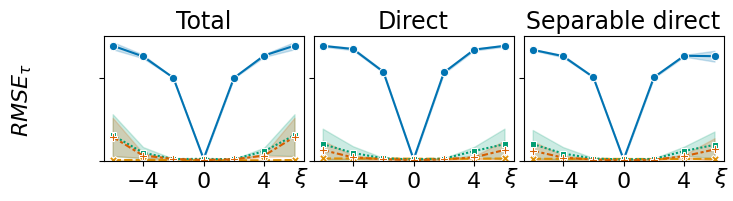

In [14]:
# main fig: risks (Fig 3, left)

plt.figure(figsize=(8, 6))
plt.subplot(3, 3, 1)
res_type = "rmse_te"
x_lab_1 = r"$\xi$"
t = 30
ylim = [0, 0.75]
plot_frame = make_plot_frame(
    res_1_mean, res_1_se, res_type=res_type, te_type="cs", subset_horizon=t
)
plot_grouped_line_with_errorbars(
    plot_frame,
    input_feature="vary_value",
    outcome_feature="metric",
    title="Total",
    xlab=x_lab_1,
    ylab=r"$RMSE_\tau$",
    std_feature="sd",
    ylim=ylim,
    labelpos_y=(-0.35, 0.5),
    labelpos_x=(0.99, -0.03),
    xticks=[-4, 0, 4],
    lab_size=16,
)

plt.subplot(3, 3, 2)
plot_frame = make_plot_frame(
    res_1_mean, res_1_se, res_type=res_type, te_type="elim", subset_horizon=t
)
plot_grouped_line_with_errorbars(
    plot_frame,
    input_feature="vary_value",
    outcome_feature="metric",
    title="Direct",
    xlab=x_lab_1,
    std_feature="sd",
    no_y=True,
    ylim=ylim,
    labelpos_x=(0.99, -0.03),
    xticks=[-4, 0, 4],
)

plt.subplot(3, 3, 3)
plot_frame = make_plot_frame(
    res_1_mean, res_1_se, res_type=res_type, te_type="sep", subset_horizon=t
)
plot_grouped_line_with_errorbars(
    plot_frame,
    input_feature="vary_value",
    outcome_feature="metric",
    title="Separable direct",
    xlab=x_lab_1,
    std_feature="sd",
    no_y=True,
    ylim=ylim,
    labelpos_x=(0.99, -0.03),
    xticks=[-4, 0, 4],
)


plt.subplots_adjust(hspace=0.35, wspace=0.05)
plt.show()